# Setup

In [21]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [22]:
%matplotlib inline

In [23]:
from relaxed.plot_defaults import *

In [24]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy

In [25]:
from relaxed.analysis import get_mah, add_box_indices, alpha_analysis, vol_jacknife_err, get_an_from_am, get_savgol_grads
from relaxed.models import training_suite, prepare_datasets

# Data

In [26]:
mah_data = get_mah('m12', '../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [27]:
# catalog
cat = mah_data['cat']

ma = mah_data['ma']
am = mah_data['am']

scales = mah_data['scales']
mass_bins = mah_data['mass_bins']

In [28]:
alphas, ma_exp, am_exp = alpha_analysis(ma, scales, mass_bins)
cat.add_column(alphas, name='alpha')

In [29]:
# prepare catalog with all a_m
am_names = [f'am_{ii}' for ii in range(len(mass_bins))]
for ii in range(len(mass_bins)):
    cat.add_column(am[:, ii], name=am_names[ii])

In [30]:
#finally diffmah jax fits.
from relaxed.analysis import get_early_late
pars = np.load('../../output/pbest_diffmah.npy')
logtc, ue, ul = pars[:, 0], pars[:, 1], pars[:, 2]
early, late = get_early_late(ue, ul)

cat.add_column(10**logtc, name='tau_c') # -> use log scale.
cat.add_column(early, name='alpha_early')
cat.add_column(late, name='alpha_late')

In [31]:
# add savitsky-golay gradients 
ks = [11, 21, 41, 81, 121, 161]
log_a = np.log(scales)
delta = abs(log_a[-1] - log_a[0]) / (200 - 1) # 200 is default number of interpolation points for uniform spacing. (in get_savgol_grads)
gamma_k = {k: -get_savgol_grads(scales, ma, k=k) for k in ks}
delta_k = {k: delta*(k//2) for k in ks}
grad_names_k = {k: [f'grad_{k}_{jj}' for jj in range(gamma_k[k].shape[1])] for k in ks }
all_grad_names = [grad_names_k[k][jj] for k in grad_names_k for jj in len(grad_names_k[k])]

# add to catalog
for k in ks: 
    for jj in range(gamma_k[k].shape[1]):
        name = grad_names_k[k][jj]
        value = gamma_k[k][:, jj]
        cat.add_column(value, name=name)


In [32]:
# add a_{1/2} also as alternative parametrization
cat.add_column(get_an_from_am(am, mass_bins, 0.5), name='a2')

In [33]:
# add box indices to cat for uncertainty purposes
add_box_indices(cat)

In [66]:
params = ('cvir',  'cvir_klypin', 't/|u|', 'x0', 'q','b_to_a', 'c_to_a',  'spin', 'spin_bullock', )
info = {
    'all': {'x': am_names, 'y': params, },
    'alpha': {'x': ('alpha',), 'y': params, },
    'diffmah': {'x':('tau_c', 'alpha_early', 'alpha_late'), 'y': params,},
    'diffmah_new': {'x':('tau_c', 'a2', 'alpha_late'), 'y': params,},
    'gradients': {'x':am_names+grad_names_k[11], 'y': params,},
    'overfitting5': {'x':am_names[::5], 'y': params,},
    'overfitting10': {'x':am_names[::10], 'y': params,}
}
datasets, cat_train, cat_test = prepare_datasets(cat, info)

# Train

In [68]:
# joint models
opcam_dict = {
'cvir': {'mbin': 0.5, 'order': -1}, 
'cvir_klypin': {'mbin': 0.397, 'order': -1}, 
't/|u|': {'mbin': 0.67, 'order': +1}, 
'x0': {'mbin': 0.738, 'order': +1}, 
'q': {'mbin': 0.67, 'order': -1},
'b_to_a': {'mbin': 0.673, 'order': -1}, 
'c_to_a': {'mbin': 0.644, 'order': -1}, 
'spin': {'mbin': 0.54, 'order': +1},
'spin_bullock': {'mbin': 0.54, 'order': +1},
 }

data ={
    'multicam': {
        'xy': datasets['all']['train'], 'n_features': 100, 'n_targets': len(params), 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'multicam_alpha': {
        'xy': datasets['alpha']['train'], 'n_features': 1, 'n_targets': len(params), 'model': 'linear',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'multicam_diffmah': {
        'xy': datasets['diffmah']['train'], 'n_features': 3, 'n_targets': len(params), 
        'model': 'linear', 'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'multicam_diffmah_new': {
        'xy': datasets['diffmah_new']['train'], 'n_features': 3, 'n_targets': len(params), 
        'model': 'linear', 'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'mixed_cam': {
        'xy': datasets['all']['train'], 'n_features': 100, 'n_targets': len(params), 
        'model': 'mixed_cam', 'kwargs':{'mass_bins':mass_bins, 
                                        'opt_mbins':[opcam_dict[param]['mbin'] for param in params], 
                                        'cam_orders':[opcam_dict[param]['order'] for param in params]
                                        },
    },
    # 'gradients': {
    #     'xy': datasets['gradients']['train'], 'n_features': 100 + 165, 'n_targets': len(params), 
    #     'model': 'linear', 'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    # },
    'overfitting5': {
        'xy': datasets['overfitting5']['train'], 'n_features': 100 // 5, 'n_targets': len(params), 
        'model': 'linear', 'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
    'overfitting10': {
        'xy': datasets['overfitting10']['train'], 'n_features': 100 // 10, 'n_targets': len(params), 
        'model': 'linear', 'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    }
}
joint_models = training_suite(data)



# Metrics whisker plots

## Setup

In [73]:
latex_metrics = {
    'mu': r"$\mu \left( y_{\rm pred} - y_{\rm true} \right)$", 
    'med': r"$\mu_{x}'$",
    'sigma_ratio': r"$\sigma_{\rm pred} / \sigma_{\rm true}$",
    'corr': r"$\rho$",
    'rscatter':r"$\frac{\sigma(y_{\rm pred} - y_{\rm true})}{\sigma(y_{\rm true})}$",
}

latex_params = {
    'cvir': r"$c_{\rm vir}$",
    't/|u|':  r"$t/\vert u \vert$",
    'x0': r"$x_{\rm off}$", 
    'spin': r"$\lambda$",
    'q': r"$q$",
    'spin_bullock': r"$\lambda_{\rm bullock}$",
    'b_to_a': r"$b/a$",
    'c_to_a': r"$c/a$",
    'cvir_klypin': r"$c_{\rm vir, klyp}$"
}

In [80]:
def compute_metrics(pred_func, _x_test, _y_test, box_keep = None):
    # pred_func should return ONLY 1 parameter. (e.g. lambda wrapped around indexing)
    if box_keep is None:
        box_keep = np.ones(_x_test.shape[0]).astype(bool)
    
    x_test = _x_test[box_keep]
    y_test = _y_test[box_keep].reshape(-1)
    
    y_pred = pred_func(x_test).reshape(-1)
    x = (y_pred - y_test) / np.std(y_test) # normalize

    return {'mu': np.mean(x), 
            'sigma_ratio': np.std(y_pred) / np.std(y_test), 
            'corr': scipy.stats.spearmanr(y_pred, y_test)[0],
            'rscatter': np.std(x) / np.sqrt(2), 
            'mad': np.mean(np.abs(x)), 
           }


def metrics_plot(metrics_data: dict, test_data: dict, trained_models: dict, 
                 cat_test, params=("cvir",), legend_size=20, figsize=(12, 12),nrows=2, ncols=2,
                 ticksize=16,
               ):
    # params and models MUST have same order (until switch to pandas...)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    model_metrics = {} 

    for jj, param in enumerate(params): 
        for mdl_name, (x_test, label, color, shape) in test_data.items():
            model = trained_models[mdl_name]
            pred_func = lambda x: model.predict(x)[:, jj]
            y_test = cat_test[param].value.reshape(-1)
            y_pred = pred_func(x_test).reshape(-1)
            x = (y_pred - y_test) / np.std(y_test)
            val_metrics = compute_metrics(pred_func, x_test, y_test)
            errs = vol_jacknife_err(cat_test, compute_metrics, pred_func, x_test, y_test, mode='dict')
            model_metrics[(param, mdl_name)] = {k:(val_metrics[k], errs[k]) for k in metrics_data}

    params_latex = [latex_params[par] for par in params]
    for ii, met in enumerate(metrics_data):
        ax = axes[ii]
        ax.set_xlim(-0.25, len(params))
        if 'yrange' in metrics_data[met]:
            if metrics_data[met]['yrange'] is not None:
                ax.set_ylim(metrics_data[met]['yrange'])
        ax.set_xticks(np.array(list(range(len(params)))))
        ax.set_xticklabels(params_latex)
        ax.tick_params(axis='x', labelsize=ticksize)
        x_bias = 0.0
        for _, (mdl_name, (x_test, label, color, marker)) in enumerate(test_data.items()):
            for jj, param in enumerate(params):
                label = label if (jj== 0 and ii==0) else None
                val, err = model_metrics[(param, mdl_name)][met]
                ax.errorbar(jj+x_bias, val, yerr=err, label=label, marker=marker, 
                            color=color, capsize=5.5, ms=9, capthick=2.0)
            x_bias+=0.2
        
        if metrics_data[met].get('hline', None) is not None:
            ax.axhline(metrics_data[met]['hline'], ls='--', color='k')
        ax.set_ylabel(latex_metrics[met], size=28)
        
        if ii == 0:
            ax.legend(prop={'size':legend_size}, bbox_to_anchor=(0.8, 1.35))
    plt.tight_layout()

## Results

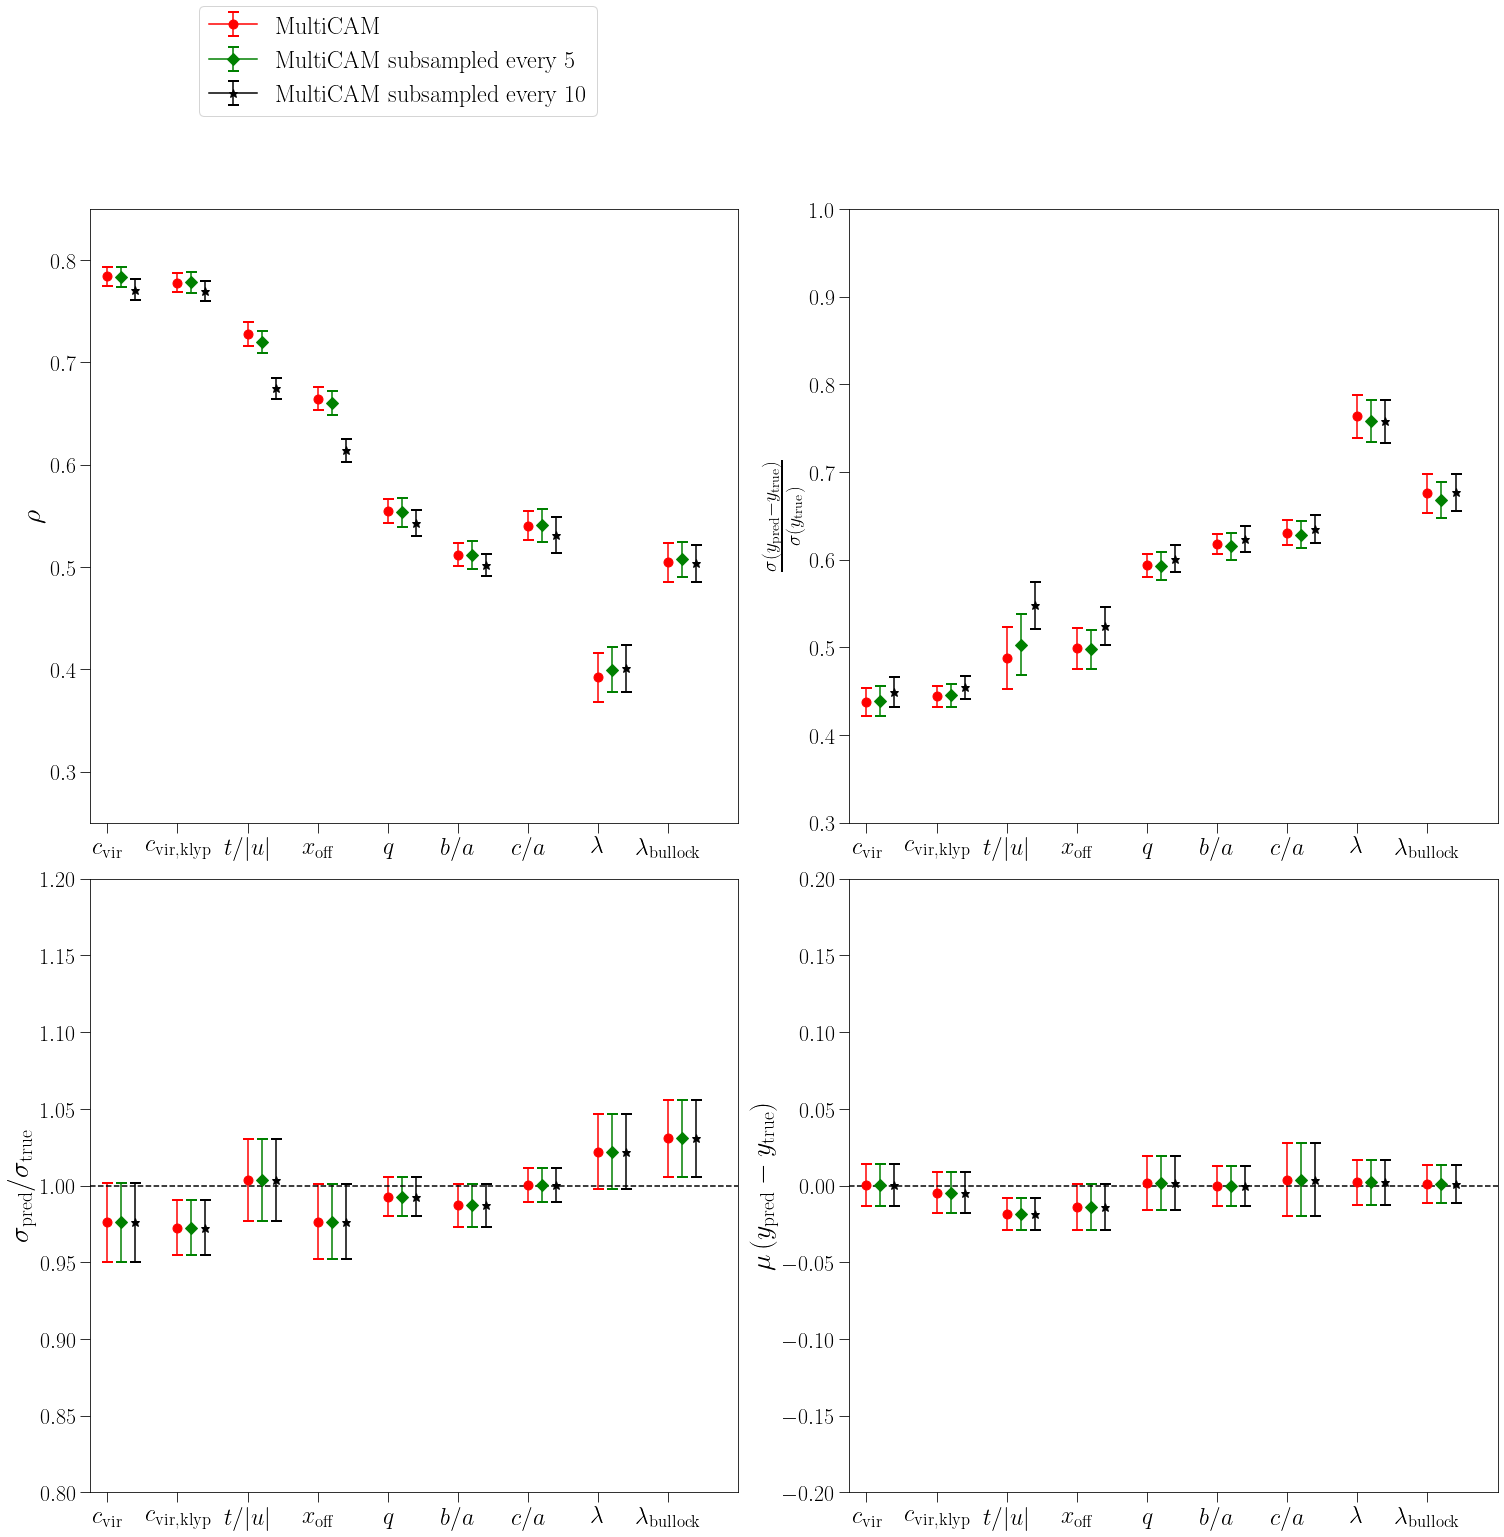

In [81]:
metrics_data = {
    'corr': {'yrange':( 0.25,0.85)},
    'rscatter': {'yrange':(0.3,1.0)},
    'sigma_ratio': {'yrange':(0.8, 1.2), 'hline': 1.0},
    'mu': {'yrange':(-0.2, 0.2), 'hline': 0.0},
}
test_data = {
    'multicam': (datasets['all']['test'][0], r"\rm MultiCAM", 'r', 'o'),
    # 'multicam_alpha': (datasets['alpha']['test'][0], r"\rm MultiCAM $\alpha$ only", 'g', 'D'),
    # 'multicam_diffmah': (datasets['diffmah']['test'][0], r"\rm MultiCAM DiffMAH parameters", 'b', 's'),
    # 'multicam_diffmah_new': (datasets['diffmah_new']['test'][0], r"\rm MultiCAM DiffMAH parameters with $a_{1/2}$", 'k', 's'),
    # 'mixed_cam': (datasets['all']['test'][0], r"\rm Optimal CAM", 'm', '^'),
    'overfitting5': (datasets['overfitting5']['test'][0], r"\rm MultiCAM subsampled every 5", 'g', 'D'),
    'overfitting10': (datasets['overfitting10']['test'][0], r"\rm MultiCAM subsampled every 10", 'k', '*'),
    # 'gradients': (datasets['gradients']['test'][0], r"\rm MultiCAM Gradients + MAH", 'k', '*'),
}
metrics_plot(metrics_data, test_data, joint_models, cat_test, params=params, 
             ncols=2, nrows=2, figsize=(21, 21), ticksize=24, legend_size=24)

